MOTIVATION

Detailed simulation of qubit-cavity coupling with two-photon sideband transitions to verify the simplified simulation of the cQED atomic beam experiment.

NOTES

- 1 ns unit for time
- Conventions:
  - [qubit, resonator ]
  - Qubit: blue
  - Resonator: red

VALUES
- N = 2
    - Single tone
        - Red sideband transitions
            - wq = 6.5, wc = 4 : wsb ~ 1.2975 * 2 * pi
            - wq = 4, wc = 6.5 : wsb ~ 1.2500 * 2 * pi (Omega = 0.3)
        - Blue sideband transitions
            - wq = 6.5, wc = 4 : wsb ~ 5.342 * 2 * pi
            - wq = 4, wc = 6.5 : wsb ~ ??? * 2 * pi
    - Two tones
        - Red sideband transitions
            - wq = 6.5, wc = 4 : wsb ~ ??? * 2 * pi
            - wq = 4, wc = 6.5 : wsb ~ ??? * 2 * pi
        - Blue sideband transitions
            - wq = 6.5, wc = 4 : wsb ~ ??? * 2 * pi
            - wq = 4, wc = 6.5 : wsb ~ ??? * 2 * pi
- N = 3
    - Single tone
        - Red sideband transitions
            - wq = 6.5, wc = 4 : wsb ~ ??? * 2 * pi
            - wq = 4, wc = 6.5 : wsb ~ ??? * 2 * pi
        - Blue sideband transitions
            - wq = 6.5, wc = 4 : wsb ~ ??? * 2 * pi
            - wq = 4, wc = 6.5 : wsb ~ ??? * 2 * pi
    - Two tones
        - Red sideband transitions
            - wq = 6.5, wc = 4 : wsb ~ ??? * 2 * pi
            - wq = 4, wc = 6.5 : wsb ~ ??? * 2 * pi
        - Blue sideband transitions
            - wq = 6.5, wc = 4 : wsb ~ ??? * 2 * pi
            - wq = 4, wc = 6.5 : wsb ~ ??? * 2 * pi

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import plots
from supports import *
from scan import sample
from qutip import *
from scipy.special import erf
from scipy.signal import argrelextrema
from ipywidgets import widgets
from IPython.display import display

options = Options()
options.store_states=True

In [2]:
Nq = 2   # number of levels in qubit
Nc = 10  # number of levels in resonator 1

wq = 6.5 *2*pi     # qubit frequency
wc = 4 *2*pi       # resonator frequency
delta = wq - wc    # detuning
Ec = 0.16 *2*pi    # anharmonicity (charging energy)
g = 0.2 *2*pi      # coupling between qubit and resonator
chi = 30e-6 *2*pi  # photon number-dependent frequency shift of qubit

Omega = 0.3 *2 *2*pi  # amplitude of sideband transitions
wd = 5.342*2*pi      # pump drive frequency
sb = 'blue'          # kind of sideband transitions (required for plotting & saving)

wq_mod = wq + Omega**2/(2*(wq-wd)) + Omega**2/(2*(wq+wd))

In [3]:
t0 = 0         # start of simulation
t1 = t0 + 0   # start of drive
t2 = t1 + 150  # end of drive
t3 = t2 + 0   # end of simulation
tg = 10        # length of gaussian rise and fall

smooth = True  # whether or not to rise and fall with gaussian
Q = 3          # number of std's in gaussian rise and fall

Np = 100*int(t3)     # number of discrete time steps for which to store the output
print("timestep =", 1e3*np.round(t3/Np, 5), "ps")

timestep = 10.0 ps


In [4]:
# Operators
b, a, nq, nc = ops(Nq, Nc)

# Jaynes-Cummings Hamiltonian
Hjc = wq*nq + wc*nc - Ec/2*b.dag()*b.dag()*b*b
Hc = g*(a*b + a*b.dag() + b*a.dag() + a.dag()*b.dag())

# Sideband transitions
Hd = Omega*(b + b.dag())

# Hamiltonian arguments
H_args = {'t0' : t0, 't1' : t1, 't2' : t2,
          't3' : t3, 'tg' : tg, 'Q'  : Q,
          'smooth' : smooth, 'wd' : wd}

# Expectation operators
e_ops = [nq, nc]

In [5]:
H = [Hjc, [Hc, drive_nonosc], [Hd, drive]]  # complete Hamiltonian
psi0 = tensor(psi_pi(Nq), basis(Nc, 1))  # initial state

# Select these options for bdf method
options.method = 'bdf'
options.rtol = 1e-10
options.atol = 1e-10

# Select these options for adams method
# options.nsteps = 1000
# options.rtol = 1e-12
# options.atol = 1e-12
# options.max_step = 0

Np_per_batch = Np/50  # number of time points per batch

In [6]:
""" CALCULATE! """

progfolder = calculate(H, psi0, e_ops, H_args, options, Nc, Np, Np_per_batch, verbose=True)

1 / 50 : 2 %
2 / 50 : 4 %
3 / 50 : 6 %
4 / 50 : 8 %
5 / 50 : 10 %
6 / 50 : 12 %
7 / 50 : 14 %
8 / 50 : 16 %
9 / 50 : 18 %
10 / 50 : 20 %
11 / 50 : 22 %
12 / 50 : 24 %
13 / 50 : 26 %
14 / 50 : 28 %
15 / 50 : 30 %
16 / 50 : 32 %
17 / 50 : 34 %
18 / 50 : 36 %
19 / 50 : 38 %
20 / 50 : 40 %
21 / 50 : 42 %
22 / 50 : 44 %
23 / 50 : 46 %
24 / 50 : 48 %
25 / 50 : 50 %
26 / 50 : 52 %
27 / 50 : 54 %
28 / 50 : 56 %
29 / 50 : 58 %
30 / 50 : 60 %
31 / 50 : 62 %
32 / 50 : 64 %
33 / 50 : 66 %
34 / 50 : 68 %
35 / 50 : 70 %
36 / 50 : 72 %
37 / 50 : 74 %
38 / 50 : 76 %
39 / 50 : 78 %
40 / 50 : 80 %
41 / 50 : 82 %
42 / 50 : 84 %
43 / 50 : 86 %
44 / 50 : 88 %
45 / 50 : 90 %
46 / 50 : 92 %
47 / 50 : 94 %
48 / 50 : 96 %
49 / 50 : 98 %
50 / 50 : 100 %
Evolution completed in 66.666849 s


In [14]:
""" SAVE """

srcfolder = progfolder #"/home/student/thesis/blue"
quants = ['times', 'expect', 'e0', 'g1', 'e1', 'g0']

start_comb = datetime.now()
print(srcfolder)
ID = getID(srcfolder)
combine_batches(srcfolder, quants=quants, return_data=False)
end_comb = datetime.now()
print("Batches combined    in {} s".format((end_comb - start_comb).total_seconds()))

times, states, expect, e0, g1, e1, g0 = load_data(quants, srcfolder)

/home/student/thesis/prog_190920_153722
Batches combined    in 1.269575 s


In [10]:
""" SIDEBAND COUPLING """

if 'eo' in quants:
    e0_macro, e0_macro_times = remove_micromotion(e0, times, method='artificial')
if 'go' in quants:
    g0_macro, g0_macro_times = remove_micromotion(g0, times, method='artificial')
if 'e1' in quants:
    e1_macro, e1_macro_times = remove_micromotion(e1, times, method='artificial')
if 'g1' in quants:
    g1_macro, g1_macro_times = remove_micromotion(g1, times, method='artificial')
if ('e1' in quants and 'g0' in quants):
    e1g0_macro, e1g0_macro_times = remove_micromotion(e1-g0, times, method='artificial')
if ('e0' in quants and 'g1' in quants):
    e0g1_macro, e0g1_macro_times = remove_micromotion(e0-g1, times, method='artificial')

if sb == 'red':
    wsb = sideband_freq(e0g1_macro, e0g1_macro_times)
elif sb == 'blue':
    wsb = sideband_freq(e1g0_macro, e1g0_macro_times)

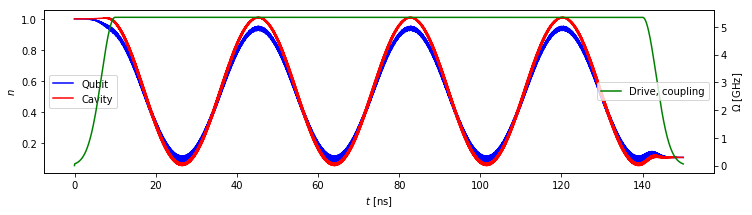

In [12]:
""" EXPECTATION VALUES """

fig, ax1 = plt.subplots(figsize=[12,3])
ax1.plot(times, expect[0], color='b', label='Qubit')
ax1.plot(times, expect[1], color='r', label='Cavity')
ax1.set_xlabel("$t$ [ns]")
ax1.set_ylabel("$n$")
ax1.tick_params(axis='y')
ax1.legend(loc='center left')

# ax1.set_xlim([20, 21])

drive_coupling = wd/(2*pi)*drive_nonosc(times, H_args)
ax2 = ax1.twinx()
ax2.plot(times, drive_coupling, color='g', label='Drive, coupling')
ax2.set_ylabel('$\Omega$ [GHz]')
ax2.tick_params(axis='y')
ax2.legend(loc='center right')

plt.show()

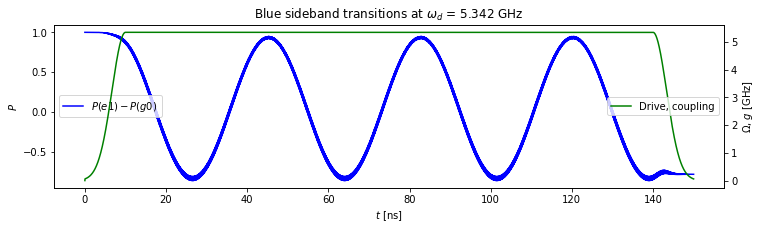

In [15]:
"""COMBINED PROBABILITIES"""

fig, ax1 = plt.subplots(figsize=[12,3])
ax1.plot(times, e1-g0, color='b', label='$P(e1) - P(g0)$')
# ax1.plot(times, e0-g1, color='r', label='$P(e0) - P(g1)$')
ax1.set_xlabel("$t$ [ns]")
ax1.set_ylabel("$P$")
ax1.tick_params(axis='y')
ax1.legend(loc='center left')

# ax1.set_xlim([27, 27.02])

drive_coupling = wd/(2*pi)*drive_nonosc(times, H_args)
ax2 = ax1.twinx()
ax2.plot(times, drive_coupling, color='g', label='Drive, coupling')
ax2.set_ylabel('$\Omega$, $g$ [GHz]')
ax2.tick_params(axis='y')
ax2.legend(loc='center right')

fig = plt.gcf()
if sb == 'red':
    plt.title("Red sideband transitions at $\\omega_d$ = {} GHz".format(round(wd/2/pi, 3)))
elif sb == 'blue':
    plt.title("Blue sideband transitions at $\\omega_d$ = {} GHz".format(round(wd/2/pi, 3)))
plt.show()

button = widgets.Button(description='Save figure')
out = widgets.Output()
def clicked(b):
    button.description = 'Figure saved!'
    with out:
        fig.savefig(srcfolder + "/" +
                    "fig_{}_{}_Nq{}_Om{}_wd{}_wq{}_wc{}_g{}_wsb{}.png".format(ID, sb, Nq,
                        round(Omega/2/pi, 2), round(wd/2/pi, 3), round(wq/2/pi, 2),
                        round(wc/2/pi, 2), round(g/2/pi, 2), round(wsb/2/pi, 4)),
                     bbox_inches='tight')
button.on_click(clicked)
widgets.VBox([button, out])

In [ ]:
"""SCANNING"""
# WDs = np.linspace(5.34*2*pi, 5.35*2*pi, 11)  # drive freq range to scan
# for WD in WDs:
#     sample(Nq, wq, wc, WD, smooth, Q, t0, t1, t2, t3, tg, psi0, Np_per_batch, options)